# CubePlusPlus Pipeline Profiling Analysis with Compression

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4


In [1]:
cream_mains_frequency_hz = 50
cream_sps = 6400
cream_period_length = cream_sps / cream_mains_frequency_hz
print(f"Cream period: {int(cream_period_length)}")
total_hours = 744
window_size_s = 10 # taken from MEED
print(f"Window Size: {window_size_s}s")
windows_per_hour = (60 * 60) / window_size_s
# float64 = 8 byte, voltage + current = "*2"
raw_data_size_per_hour_mb = windows_per_hour * window_size_s * cream_sps * 8 * 2 / 1000 / 1000
print(f"Data per hour: {raw_data_size_per_hour_mb}MB")
samples_per_hour = cream_sps * 60 * 60
print(f"Samples per hour: {samples_per_hour}")
samples_per_window_size = cream_sps * window_size_s
print(f"Samples per windowsize: {samples_per_window_size}")
full_dataset_windowcount = total_hours * windows_per_hour
print(f"Windows Total: {int(full_dataset_windowcount)}")

for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_windowcount * 100, 2)}%")
    
full_dataset_samplecount = int(full_dataset_windowcount)

Cream period: 128
Window Size: 10s
Data per hour: 368.64MB
Samples per hour: 23040000
Samples per windowsize: 64000
Windows Total: 267840
500 of total: 0.19%
1000 of total: 0.37%
2000 of total: 0.75%
4000 of total: 1.49%
8000 of total: 2.99%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
compression_palette = sns.color_palette("Spectral",3)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [3]:
local_fig_dir = "cream-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/final-logs/cream/compression"
path_to_cum_df = f"{home_path}/cream-compression-GZIP-none-ZLIB-storage-ceph-hdd_2021-09-30-12:44:02_cum-df_samples-267840_threads-8.csv"
path_to_cum_dstat_df = f"{home_path}/cream-compression-GZIP-none-ZLIB-storage-ceph-hdd_2021-09-30-12:44:02_cum-dstat-df_samples-267840_threads-8.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# we forgot to remove the "list-files" step from the profiling, so we do it in this log processing
cum_df = cum_df.query("split_name!='1-list-files'")
cum_dstat_df = cum_dstat_df.query("split_name!='1-list-files'")
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["decoded", "aggregated"]
print(strategies)

['2-voltage-+-current-extraction-6.4khz', '3-active-power-+-rms-current-+-cumsum-rms-current']


In [4]:
cum_df

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
1,13301.434570,8,8,220433.984375,267840,6313.468262,42.423592,0,1,adb947,2-voltage-+-current-extraction-6.4khz,2021-09-30-12:44:02,GZIP,ceph-hdd
40,13171.042969,8,8,220433.921875,267840,6705.701660,39.942127,0,1,74b36e,2-voltage-+-current-extraction-6.4khz,2021-10-03-10:58:44,ZLIB,ceph-hdd
37,13151.483398,8,8,220434.093750,267840,6203.979980,43.172287,0,1,bf674e,2-voltage-+-current-extraction-6.4khz,2021-10-02-08:36:58,ZLIB,ceph-hdd
34,13100.888672,8,8,220434.015625,267840,6139.881836,43.622990,0,1,f4ebc4,2-voltage-+-current-extraction-6.4khz,2021-10-01-05:39:26,ZLIB,ceph-hdd
31,13185.405273,8,8,220434.218750,267840,6549.917480,40.892117,0,1,b8e01e,2-voltage-+-current-extraction-6.4khz,2021-09-30-02:37:47,ZLIB,ceph-hdd
28,2633.963623,8,8,262487.062500,267840,6413.152344,41.764172,0,1,68a3d5,2-voltage-+-current-extraction-6.4khz,2021-10-04-06:56:07,none,ceph-hdd
25,2522.189697,8,8,262487.062500,267840,6326.346191,42.337234,0,1,800c08,2-voltage-+-current-extraction-6.4khz,2021-10-03-04:07:29,none,ceph-hdd
43,13646.397461,8,8,220433.843750,267840,6564.994629,40.798206,0,1,65a5b4,2-voltage-+-current-extraction-6.4khz,2021-10-04-13:59:19,ZLIB,ceph-hdd
19,2534.065674,8,8,262487.062500,267840,6497.405762,41.222607,0,1,7dc511,2-voltage-+-current-extraction-6.4khz,2021-09-30-22:38:43,none,ceph-hdd
16,2588.751465,8,8,262487.062500,267840,6072.311035,44.108410,0,1,a8d271,2-voltage-+-current-extraction-6.4khz,2021-09-29-19:58:00,none,ceph-hdd


In [5]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,...,vm_allocated_mb,vm_free_mb,filesystem_files,filesystem_inodes,filelocks_posix,filelocks_lock,filelocks_read,filelocks_write,compression_type,storage_type
7842,0.0,0.014671,0.083739,0.000000,0.000000,0,267840,8,8,adb947,...,0.09,0.09,1344.0,13772.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
7843,1.0,0.000000,0.000000,109.113472,0.299617,0,267840,8,8,adb947,...,0.17,0.12,1344.0,13797.0,3.0,4.0,2.0,5.0,GZIP,ceph-hdd
7844,2.0,0.000000,0.245760,147.928146,0.399456,0,267840,8,8,adb947,...,0.12,0.05,1344.0,13828.0,3.0,6.0,4.0,5.0,GZIP,ceph-hdd
7845,3.0,0.000000,0.000000,135.412399,0.326137,0,267840,8,8,adb947,...,0.13,0.06,1344.0,13848.0,3.0,8.0,6.0,5.0,GZIP,ceph-hdd
7846,4.0,0.000000,0.024576,77.109276,0.181154,0,267840,8,8,adb947,...,0.19,0.03,1344.0,13857.0,3.0,10.0,8.0,5.0,GZIP,ceph-hdd


## 0. Experiment Information

### 0.1 Experiment Count

We want to profile each strategy with each compression at least 5 times. 

In [6]:
experiment_count_dict = {
    "split_name": []
  , "compression_type": []
  , "count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(split_name, compression_type, count):
    '''Short helper'''
    experiment_count_dict["split_name"] += [split_name]
    experiment_count_dict["compression_type"] += [compression_type]
    experiment_count_dict["count"] += [count]

for split_name in cum_df["split_name"].unique():
    for compression in cum_df["compression_type"].unique():
        experiment_count = get_experiment_count(cum_df.query(f"split_name=='{split_name}' and compression_type=='{compression}'"))
        add_to_dict(split_name, compression, experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,split_name,compression_type,count
0,2-voltage-+-current-extraction-6.4khz,GZIP,5
1,2-voltage-+-current-extraction-6.4khz,ZLIB,5
2,2-voltage-+-current-extraction-6.4khz,none,5
3,3-active-power-+-rms-current-+-cumsum-rms-current,GZIP,5
4,3-active-power-+-rms-current-+-cumsum-rms-current,ZLIB,5
5,3-active-power-+-rms-current-+-cumsum-rms-current,none,5


In [7]:
# order should be "none" -> "GZIP" -> "ZLIB"

cum_df_ord = cum_df.copy(deep=True)
order_dict = { "none": 10, "GZIP": 11, "ZLIB": 12 }
cum_df_ord = cum_df_ord.sort_values(by=['compression_type', 'split_name'], key=lambda x: x.map(order_dict))
cum_df_ord

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
28,2633.963623,8,8,262487.062500,267840,6413.152344,41.764172,0,1,68a3d5,2-voltage-+-current-extraction-6.4khz,2021-10-04-06:56:07,none,ceph-hdd
25,2522.189697,8,8,262487.062500,267840,6326.346191,42.337234,0,1,800c08,2-voltage-+-current-extraction-6.4khz,2021-10-03-04:07:29,none,ceph-hdd
19,2534.065674,8,8,262487.062500,267840,6497.405762,41.222607,0,1,7dc511,2-voltage-+-current-extraction-6.4khz,2021-09-30-22:38:43,none,ceph-hdd
16,2588.751465,8,8,262487.062500,267840,6072.311035,44.108410,0,1,a8d271,2-voltage-+-current-extraction-6.4khz,2021-09-29-19:58:00,none,ceph-hdd
22,2550.883301,8,8,262487.062500,267840,6607.694336,40.534565,0,1,eff71f,2-voltage-+-current-extraction-6.4khz,2021-10-02-01:31:41,none,ceph-hdd
17,7855.635742,8,8,3090.450195,267840,32.349430,8279.588867,0,1,f4e1ab,3-active-power-+-rms-current-+-cumsum-rms-current,2021-09-29-19:58:00,none,ceph-hdd
29,8318.166016,8,8,3090.450195,267840,31.417198,8525.266602,0,1,d5d9d5,3-active-power-+-rms-current-+-cumsum-rms-current,2021-10-04-06:56:07,none,ceph-hdd
26,8029.126465,8,8,3090.450195,267840,32.660156,8200.818359,0,1,38b4ae,3-active-power-+-rms-current-+-cumsum-rms-current,2021-10-03-04:07:29,none,ceph-hdd
23,8289.500000,8,8,3090.450195,267840,31.980165,8375.191406,0,1,52e5ac,3-active-power-+-rms-current-+-cumsum-rms-current,2021-10-02-01:31:41,none,ceph-hdd
20,8181.541016,8,8,3090.450195,267840,31.552504,8488.708984,0,1,4ac435,3-active-power-+-rms-current-+-cumsum-rms-current,2021-09-30-22:38:43,none,ceph-hdd


# 3. Compression
## 3.1 Compression Rate for each strategy

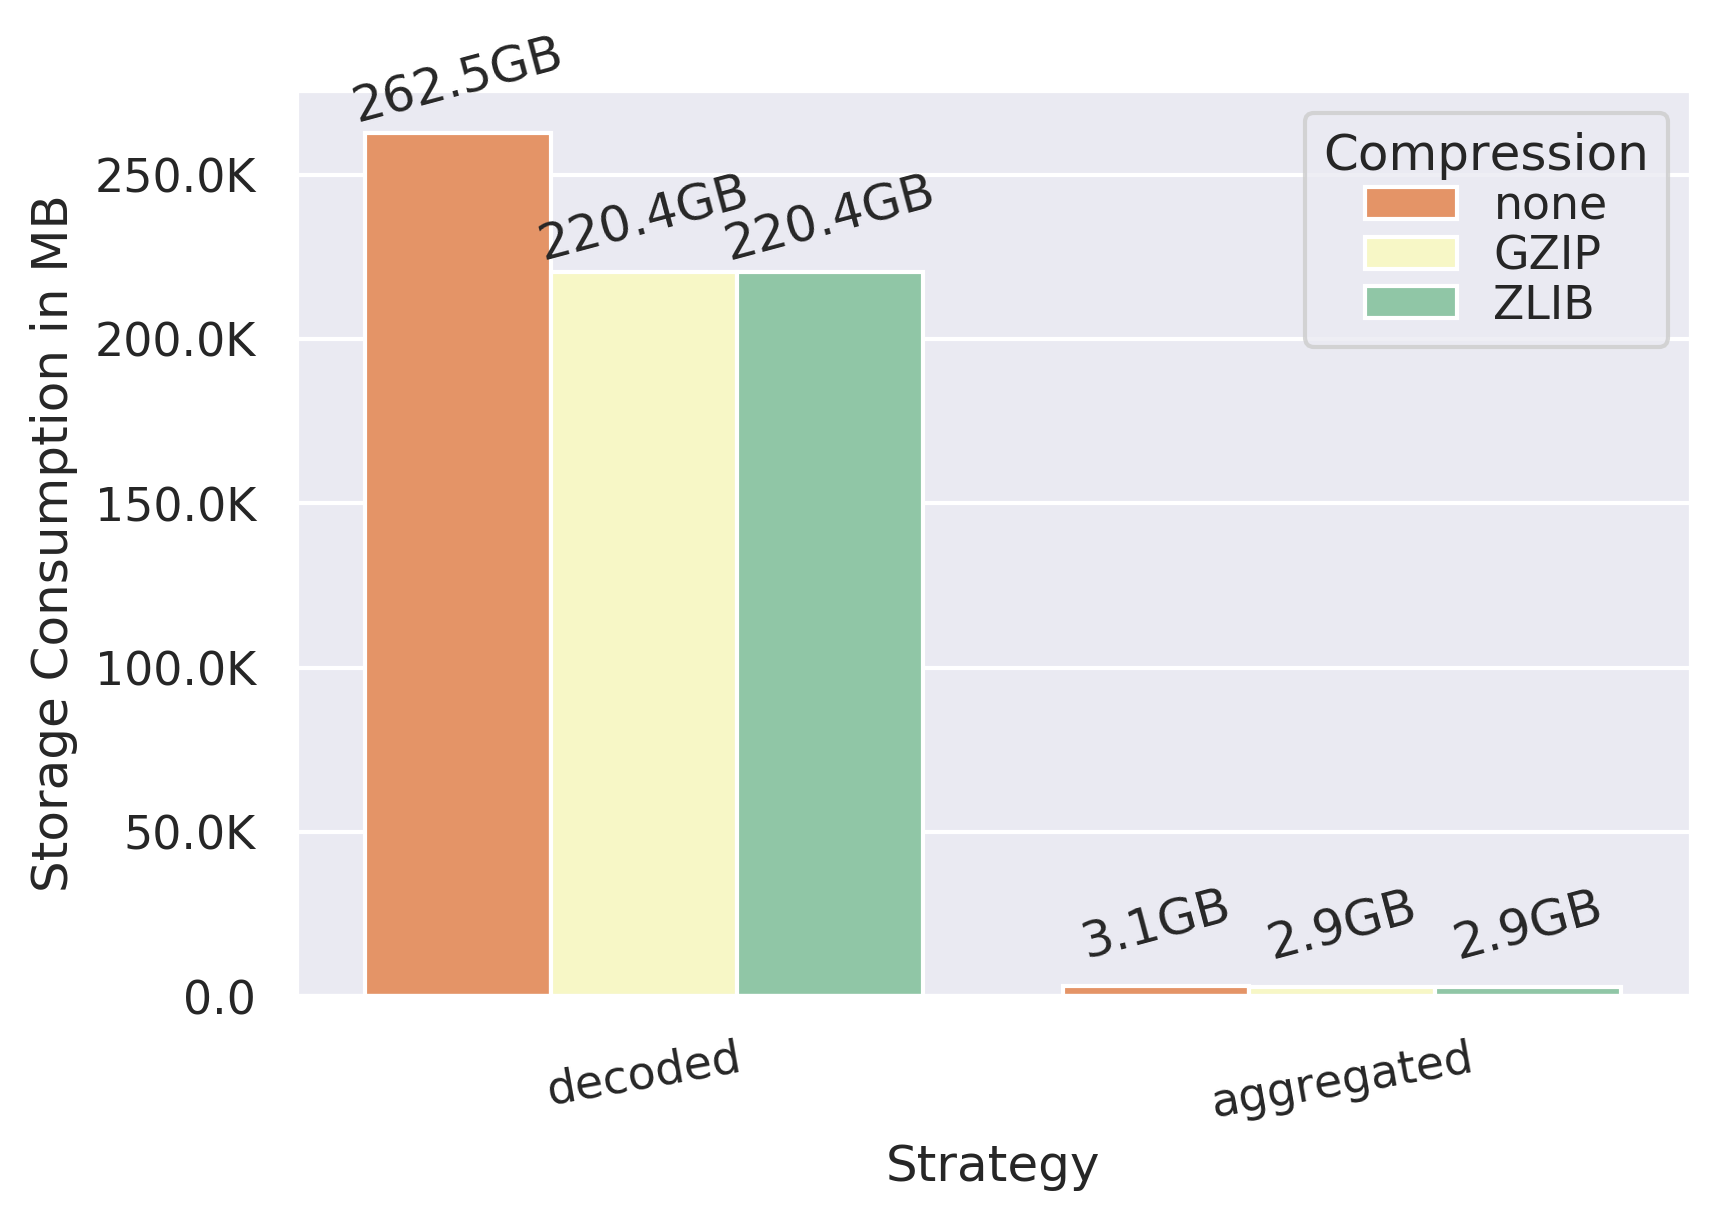

In [8]:
sns.set(palette=compression_palette)
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier


cum_df_temp = cum_df_ord

plot = sns.barplot(
    x="split_name",
    y="shard_cum_size_MB",
    hue="compression_type",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
#plot.set(ylim=(0, 1650000))
plot.set(xlabel="Strategy", ylabel="Storage Consumption in MB")
plot.legend(title="Compression", ncol=1, labelspacing=0.1)
plot.yaxis.set_major_formatter(make_big_number_prettier)
show_values_on_bars(plot, h_v="v", space=20000, rotation=15, storage_formatting=True, storage_round=1)
#                    , additional_space=[50000,-50000,0,-50000
#                                       ,0,0,0,0
#                                       ,-50000,-50000,-50000,-50000])

#save_fig("compressed-storage-consumption")

## 3.2 Storage and Throughput for each strategy

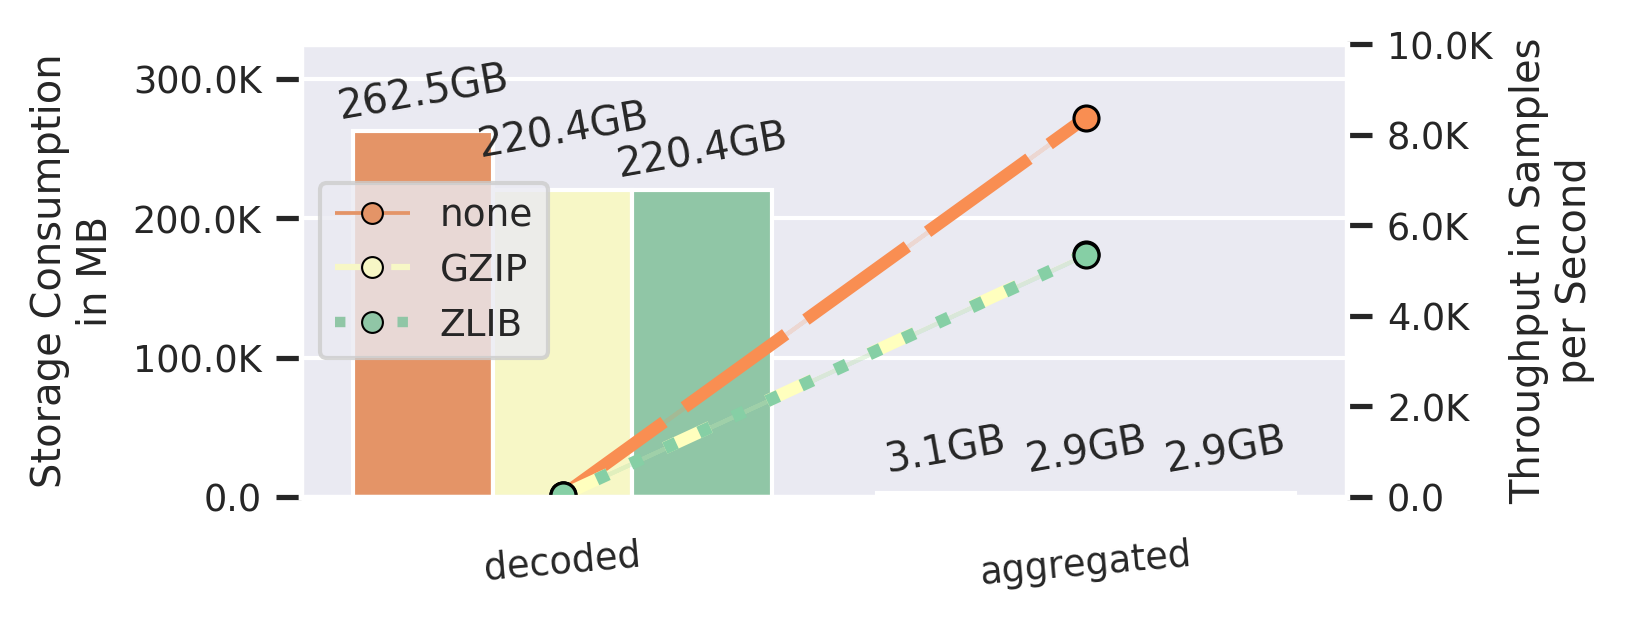

In [10]:
from matplotlib.lines import Line2D

sns.set(palette=compression_palette,font_scale=0.8)
marker = 'o'
linestyle = [(10,2), (4,5), (1,2)]
linestyle2 = [(0,(10,2)), (0,(4,5)), (0,(1,2))]

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()

## throughput plot
plot2 = sns.lineplot(
    x="split_name",
    y="throughput_sps",
    hue="compression_type",
    data=cum_df_temp,
    ax=ax2,
    marker=marker,
    size=3,
    sizes=(3,3),
    dashes=linestyle,
    ci=0.95,
    markeredgecolor='black',
    style='compression_type')

plot2.set(ylabel="Throughput in Samples\nper Second")
ax2.grid(False)
legend_elements = [
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=0.9, label='none', color="#E49467", linestyle=linestyle2[0]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=1.5, label='GZIP', color="#F7F7C6", linestyle=linestyle2[1]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=2.5, label='ZLIB', color="#90C6A6", linestyle=linestyle2[2])]
ax2.legend(handles=legend_elements, loc="center left", prop={'size': 9})
plot2.set(ylim=(0, 10000))         

plot = sns.barplot(
        x="split_name",
        y="shard_cum_size_MB",
        hue="compression_type",
        data=cum_df_temp,
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.yaxis.set_major_formatter(make_big_number_prettier)
show_values_on_bars(plot, h_v="v", space=30000, rotation=10, storage_formatting=True, storage_round=1,
                    additional_space=[0,0
                                     ,15000,0
                                     ,0,0])

plot.set(ylim=(0, 325000))
ax1.get_legend().remove()
plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("compressed-storage-vs-throughput")

## 3.3 Throughput for each compression and each strategy

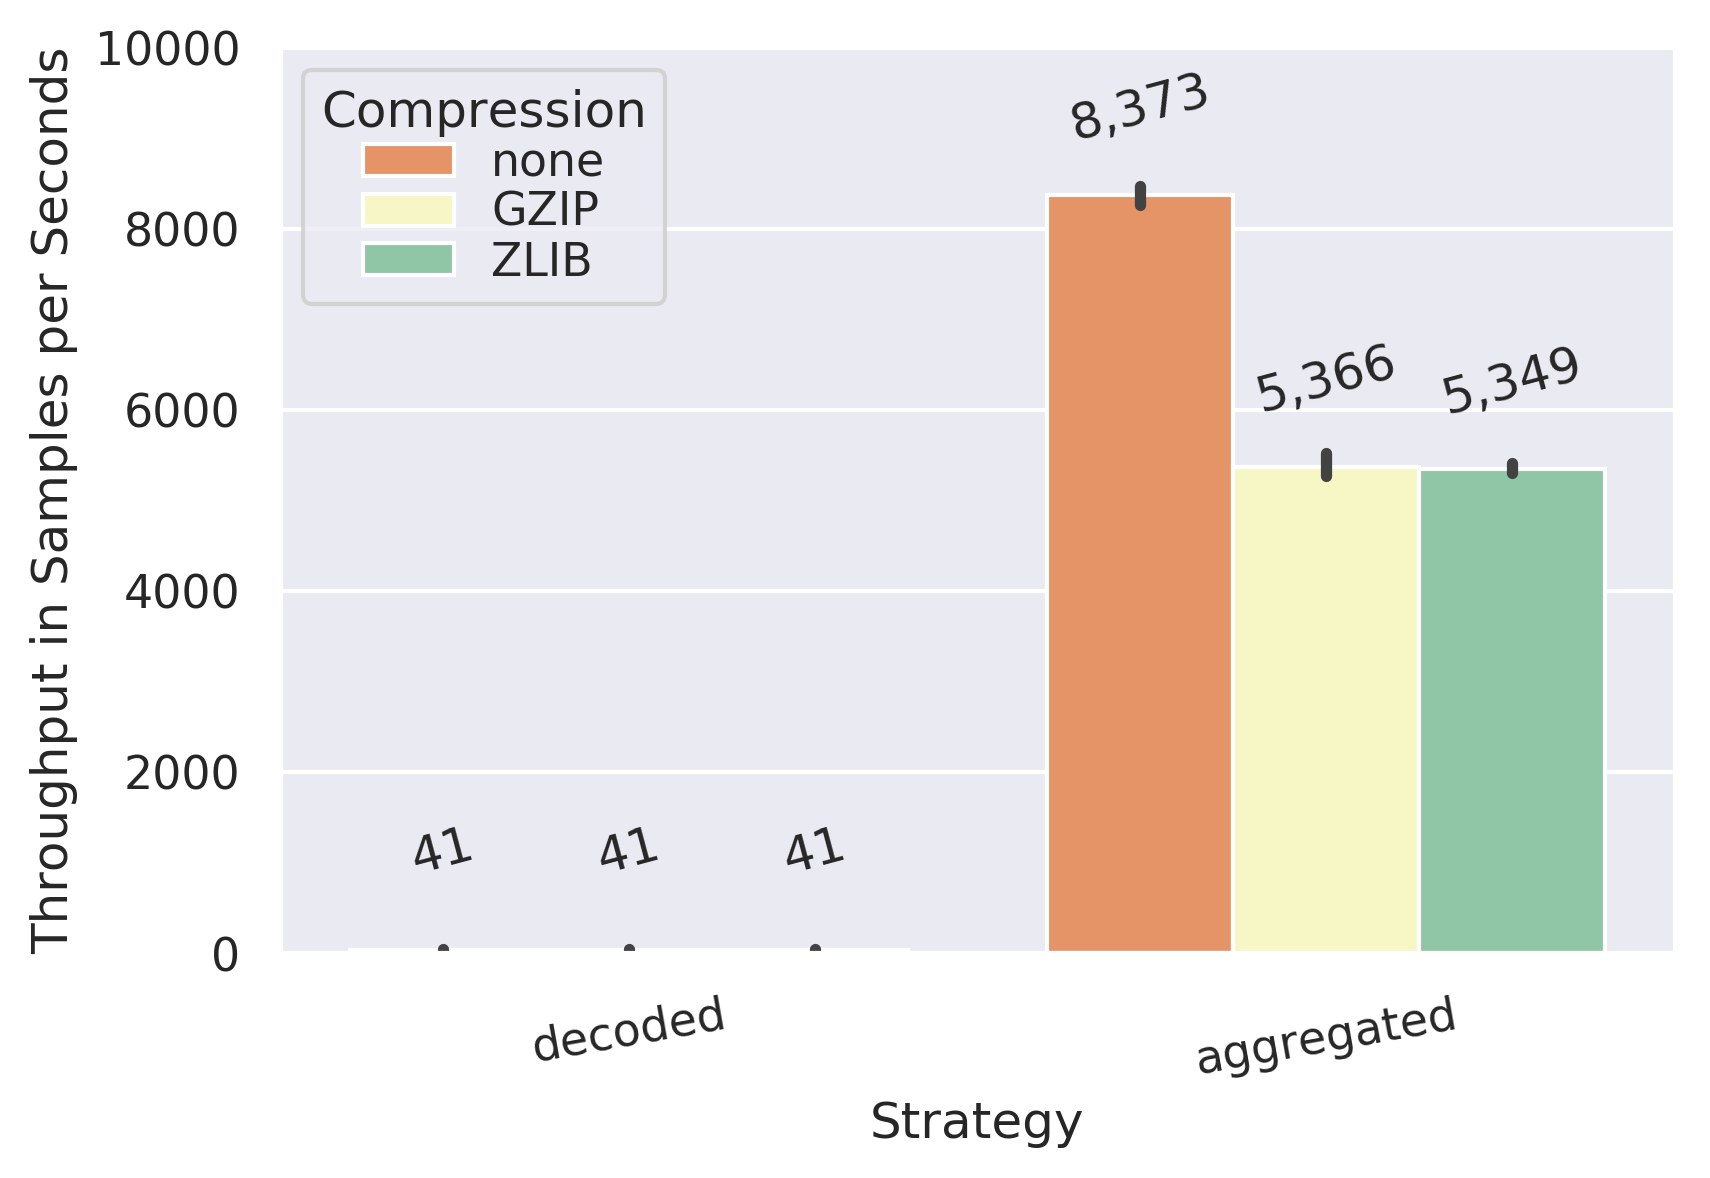

In [17]:
sns.set(palette=compression_palette)

cum_df_temp = cum_df_ord

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="compression_type",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 10000))
plot.legend(title="Compression", ncol=1, labelspacing=0.1, loc="upper left")
show_values_on_bars(plot, h_v="v", space=1000, rotation=15)

#save_fig("compression-throughput")

## 3.3 Full Dataset Processing Split

### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [18]:
# calculate the per sample processing time for both offline and online processing
cum_df_ord["per_sample_online_processing_time_s"] = cum_df_ord["online_processing_time_s"] / cum_df_ord["sample_count"]
cum_df_ord["per_sample_offline_processing_and_save_time_s"] = cum_df_ord["offline_processing_and_save_time_s"] / cum_df_ord["sample_count"]
# calculate the total processing time for each sample count
cum_df_ord["total_processing_time_s"] = cum_df_ord["online_processing_time_s"] + cum_df_ord["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df_ord["full_dataset_online_processing_time_s"] = cum_df_ord["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_s"] = cum_df_ord["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_m"] = cum_df_ord["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df_ord["full_dataset_offline_processing_and_save_time_h"] = cum_df_ord["full_dataset_offline_processing_and_save_time_m"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df_ord["full_dataset_processing_time_s"] = cum_df_ord["full_dataset_online_processing_time_s"] + cum_df_ord["full_dataset_offline_processing_and_save_time_s"]
cum_df_ord["full_dataset_processing_time_m"] = cum_df_ord["full_dataset_processing_time_s"] / 60
cum_df_ord["full_dataset_processing_time_h"] = cum_df_ord["full_dataset_processing_time_m"] / 60 

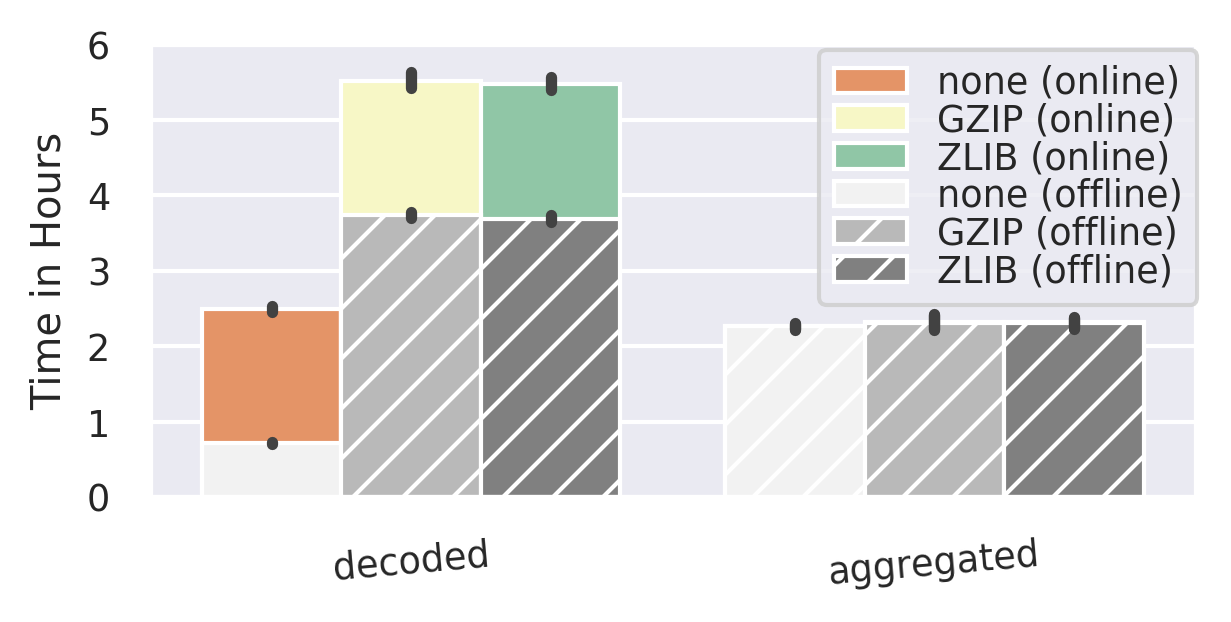

In [25]:
cum_df_temp = cum_df_ord

sns.set(palette=compression_palette, font_scale=0.8)
fig, ax1 = plt.subplots(figsize=(4.5,2))

plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="compression_type",
    data=cum_df_temp
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_h",
    hue="compression_type",
    data=cum_df_temp,
    color="grey"
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)

sample_counts = len(cum_df_temp.compression_type.unique())
strategies_count = len(cum_df_temp.split_name.unique())

for i,bar in enumerate(plot.patches):
    if i > (sample_counts * strategies_count):
        bar.set_hatch("//")

plot.set(xlabel="", ylabel="Time in Hours")
plot.set(ylim=(0, 6))

handles, labels = plot.get_legend_handles_labels()

def add_status_to_handle(handle, index):
    compression_count = 3
    label = handle.get_label()
    if index >= compression_count:
        new_label = label + ' (offline)'
    else:
        new_label = label + ' (online)'
    handle.set_label(new_label)
    
for i, handle in enumerate(handles):
    add_status_to_handle(handle,index=i)

plot.legend(handles=handles, title="", loc=(0.64,0.425), ncol=1, labelspacing=0.02, columnspacing=0.3)
save_fig("compression-processing-time-split")

# X. Misc Plots and Calculations

## X.1 -

In [20]:
space_dict = {
    "strategy": []
   ,"space_saving_gzip": []
   ,"space_saving_zlib": []
   ,"sps_increase_gzip_fac": []
   ,"sps_increase_zlib_fac": []
}

def add_to_dict(strategy, ss_gzip, ss_zlib, sps_gzip, sps_zlib):
    space_dict["strategy"].append(strategy)
    space_dict["space_saving_gzip"].append(ss_gzip)
    space_dict["space_saving_zlib"].append(ss_zlib)
    space_dict["sps_increase_gzip_fac"].append(sps_gzip)
    space_dict["sps_increase_zlib_fac"].append(sps_zlib)
    
    
def space_saving(compressed, original):
    return round((1 - (compressed / original)) * 100, 2)

def throughput_increase(compressed, original):
    return round(compressed / original, 2)
    
for split_name in cum_df.split_name.unique():
    
    temp_df = cum_df.query(f"split_name=='{split_name}'")
    original_size = temp_df.query("compression_type=='none'").mean()["shard_cum_size_MB"]
    original_sps = temp_df.query("compression_type=='none'").mean()["throughput_sps"]
    gzip_size = temp_df.query("compression_type=='GZIP'").mean()["shard_cum_size_MB"]
    gzip_sps = temp_df.query("compression_type=='GZIP'").mean()["throughput_sps"]
    zlib_size = temp_df.query("compression_type=='ZLIB'").mean()["shard_cum_size_MB"]
    zlib_sps = temp_df.query("compression_type=='ZLIB'").mean()["throughput_sps"]

    print(f"Strategy: {split_name}")
    print(f"- Orig: {round(original_size, 2)}MB")
    print(f"- Orig: {round(original_sps, 2)}sps")
    print(f"- GZIP: {round(gzip_size, 2)}MB")
    print(f"- GZIP: {round(gzip_sps, 2)}sps")
    print(f"- ZLIB: {round(zlib_size, 2)}MB")    
    print(f"- ZLIB: {round(zlib_sps, 2)}sps")
    add_to_dict(strategy = split_name
               ,ss_gzip = space_saving(compressed = gzip_size, original = original_size)
               ,ss_zlib = space_saving(compressed = zlib_size, original = original_size)
               ,sps_gzip = throughput_increase(compressed = gzip_sps, original = original_sps)
               ,sps_zlib = throughput_increase(compressed = zlib_sps, original = original_sps))
    
pd.DataFrame(space_dict)    

Strategy: 2-voltage-+-current-extraction-6.4khz
- Orig: 262487.06MB
- Orig: 41.99sps
- GZIP: 220434.0MB
- GZIP: 41.99sps
- ZLIB: 220434.03MB
- ZLIB: 41.69sps
Strategy: 3-active-power-+-rms-current-+-cumsum-rms-current
- Orig: 3090.45MB
- Orig: 8373.92sps
- GZIP: 2912.27MB
- GZIP: 5366.15sps
- ZLIB: 2912.27MB
- ZLIB: 5349.54sps


,strategy,space_saving_gzip,space_saving_zlib,sps_increase_gzip_fac,sps_increase_zlib_fac
0,2-voltage-+-current-extraction-6.4khz,16.02,16.02,1.00,0.99
1,3-active-power-+-rms-current-+-cumsum-rms-current,5.77,5.77,0.64,0.64


## X.2 Warning - Creating the plots based on `dstat` logs can take several hours

In [104]:
cum_dstat_df_copy = cum_dstat_df.copy(deep=True)
cum_dstat_df_copy["sample_count"] = cum_dstat_df_copy.sample_count.astype('category')
cum_dstat_df_copy["split_name"] = cum_dstat_df_copy.split_name.astype('category')
cum_dstat_df_copy["run"] = cum_dstat_df_copy.run.astype('category')
cum_dstat_df_copy["thread_count"] = cum_dstat_df_copy.thread_count.astype('category')
strategy_list = list(cum_dstat_df_copy.split_name.unique())
strategy_list

['2-read-image', '3-decode-image', '4-resize-image', '5-center-pixel-values']

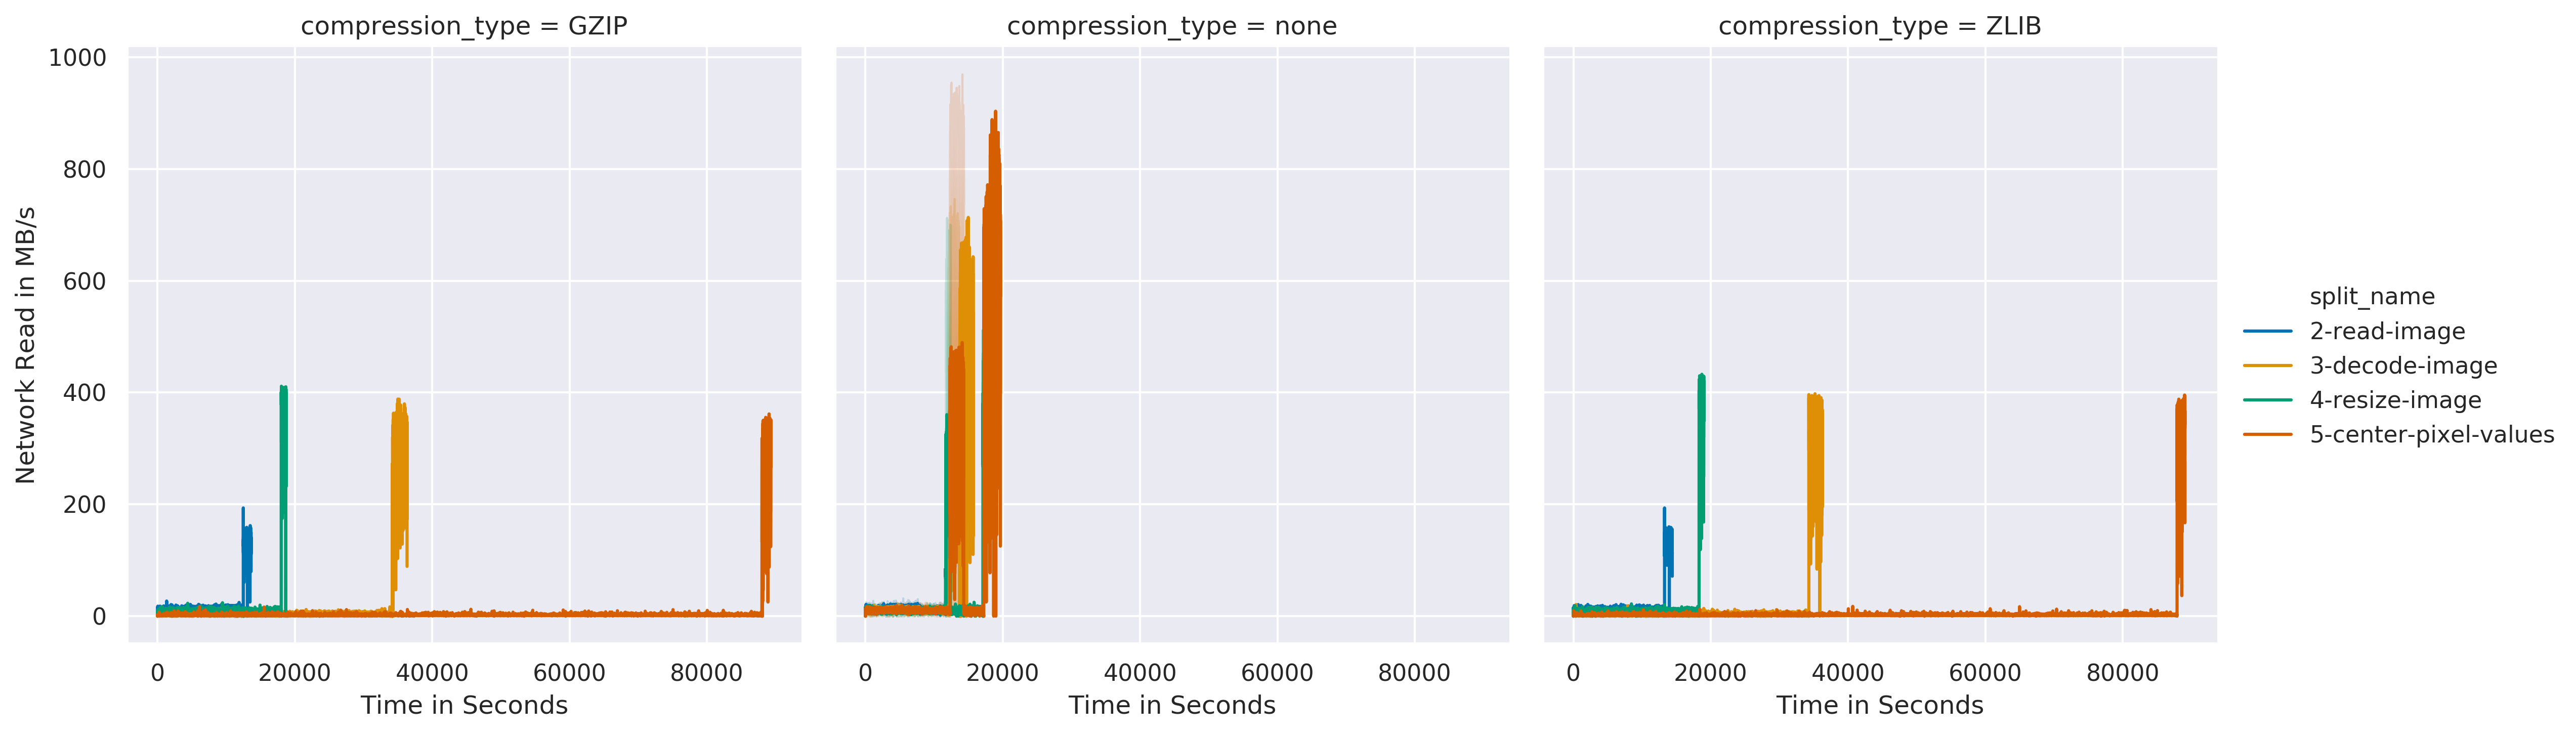

In [105]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    col="compression_type",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

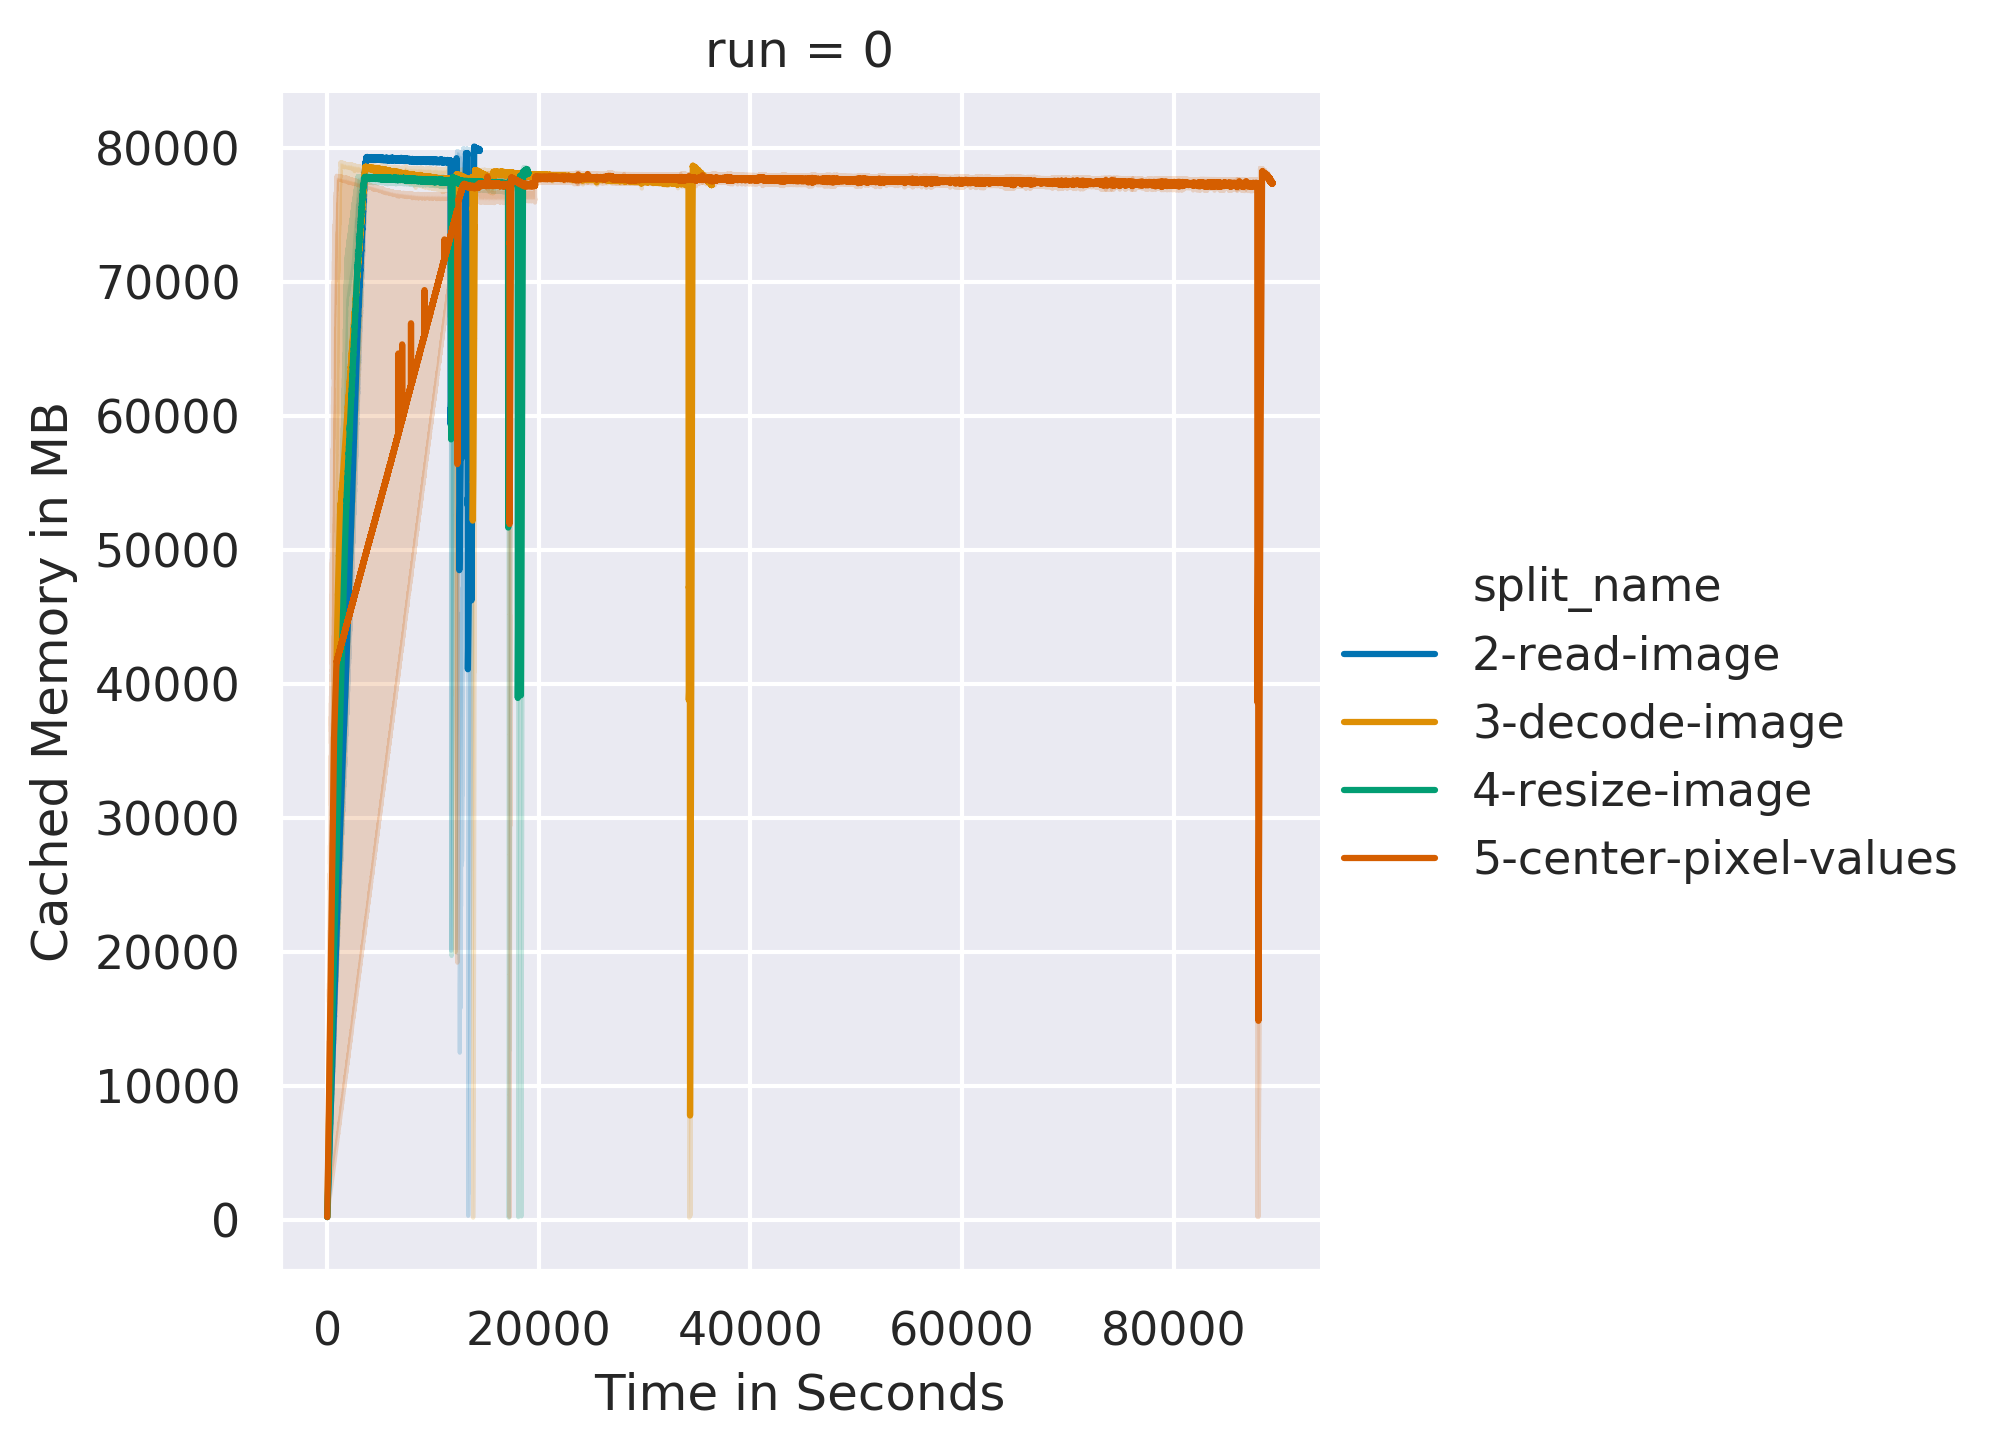

In [106]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy

plot = sns.relplot(
    x="rel_time_s",
    y="memory_cached_mb",
    hue="split_name",
    col="run",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Cached Memory in MB")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")